In [1]:
import numpy as np

from audio_ot import *

# Synthetic sounds: same note, milliseconds apart

Compute 2D-OT between STFT of same note but milliseconds apart (horizontal displacement)

In [2]:
sr = 44100
total_duration = 2
event_duration = 0.1
start = 0.1
interval = 0.8

f0 = 440

source_signal = np.zeros(int(sr * total_duration))
target_signal = np.zeros(int(sr * total_duration))


for f in range(int(event_duration * sr)):
    source_signal[int(start * sr) + f] = np.sin(2*np.pi*f*f0 / sr)
    target_signal[int((start + interval) * sr) + f] = np.sin(2*np.pi*f*f0 / sr)

smooth_len = 2000
if smooth_len > 0:
    smoothing = np.linspace(0, 1, smooth_len)
    source_signal[int(start * sr):smooth_len + int(start * sr)] *= smoothing
    source_signal[int((start + event_duration) * sr)-smooth_len:int((start + event_duration) * sr)] *= np.flip(smoothing)
    target_signal[int((start + interval) * sr):smooth_len + int((start + interval) * sr)] *= smoothing
    target_signal[int((start + interval + event_duration) * sr)-smooth_len:int((start + interval + event_duration) * sr)] *= np.flip(smoothing)

signals = [source_signal, target_signal]
titles = ['source', 'target']
audio_widgets = [audio_widget(signal, title) for signal, title in zip(signals, titles)]

grid = widgets.VBox(audio_widgets)
grid

In [3]:
from math import log2, ceil

window_size = 20 # ms
window_size_samples = window_size * 1e-3 * sr
n_fft = 2 ** ceil(log2(window_size_samples))
hop_length = n_fft // 4
source_stft = librosa.stft(source_signal, n_fft=n_fft, hop_length=hop_length)
target_stft = librosa.stft(target_signal, n_fft=n_fft, hop_length=hop_length)

frequencies = librosa.fft_frequencies(sr=sr, n_fft=n_fft)

/tmp/ipykernel_54762/3297339406.py:6: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  img = librosa.display.specshow(librosa.amplitude_to_db(spectrogram, ref=np.max),


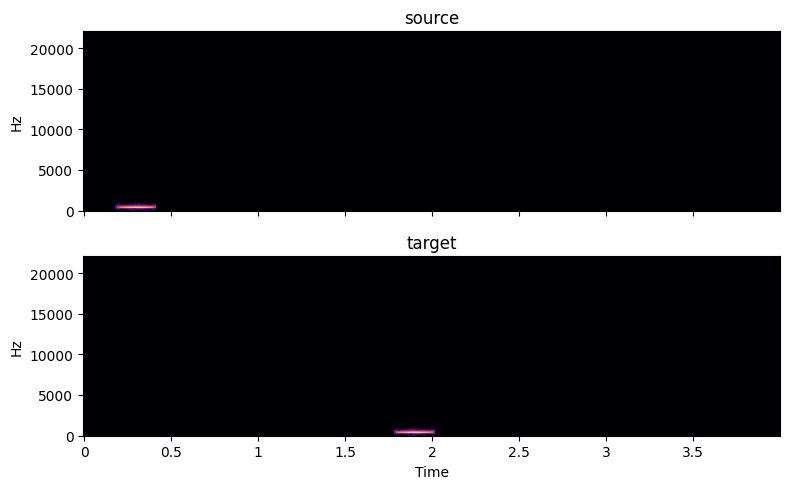

In [4]:
fig, axs = plt.subplots(2, 1, figsize=(8, 5), sharex=True, sharey=True)
titles = ['source', 'target']
spectrograms = [source_stft, target_stft]

for ax, spectrogram, title in zip(axs.flatten(), spectrograms, titles):
    img = librosa.display.specshow(librosa.amplitude_to_db(spectrogram, ref=np.max),
                                   ax=ax,
                                   x_axis='time', # issue
                                   y_axis='linear',
                                   sr=sr)
    ax.set_title(title)
    ax.label_outer()

plt.tight_layout()
plt.show()


In [5]:
# source_stft.shape is too big for cost matrix
# truncate high frequencies

top_freq = 1000
top = frequency_to_index(frequencies, top_freq)

frequency_to_index(frequencies, 440)

source = source_stft[:top, :]
source = np.abs(source)
source = source / np.sum(source)
target = target_stft[:top, :]
target = np.abs(target)
target = target / np.sum(target)

In [6]:
support = np.zeros((source.shape[0] * source.shape[1], 2))

index = 0
for i in range(source.shape[0]):
    for j in range(source.shape[1]):
        support[index] = [j, i]
        index += 1
        

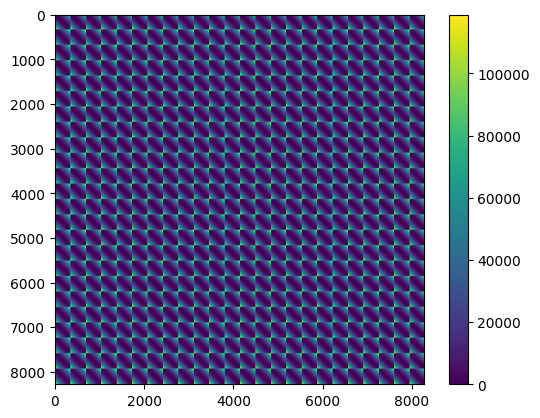

In [7]:
M = ot.dist(support, support)

plt.imshow(M)
plt.colorbar()

In [8]:
flat_source = source.flatten()
flat_target = target.flatten()

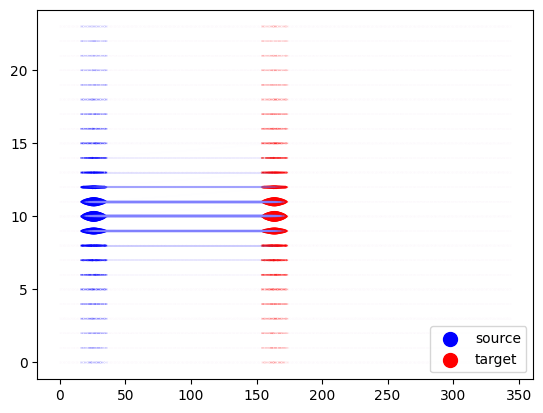

In [9]:
import ot.plot

plan = ot.emd(flat_source, flat_target, M)

source_clipped = np.clip(flat_source, 1e-8, None)
target_clipped = np.clip(flat_target, 1e-8, None)

plt.scatter(support[:,0], support[:,1], c="b", s=source_clipped*1000)
plt.scatter(support[:,0], support[:,1], c="r", s=target_clipped*1000)
ot.plot.plot2D_samples_mat(support, support, plan, c=[0.5, 0.5, 1])

plt.scatter([], [], c="b", label="source", s=100)
plt.scatter([], [], c="r", label="target", s=100)
plt.legend(loc="lower right")

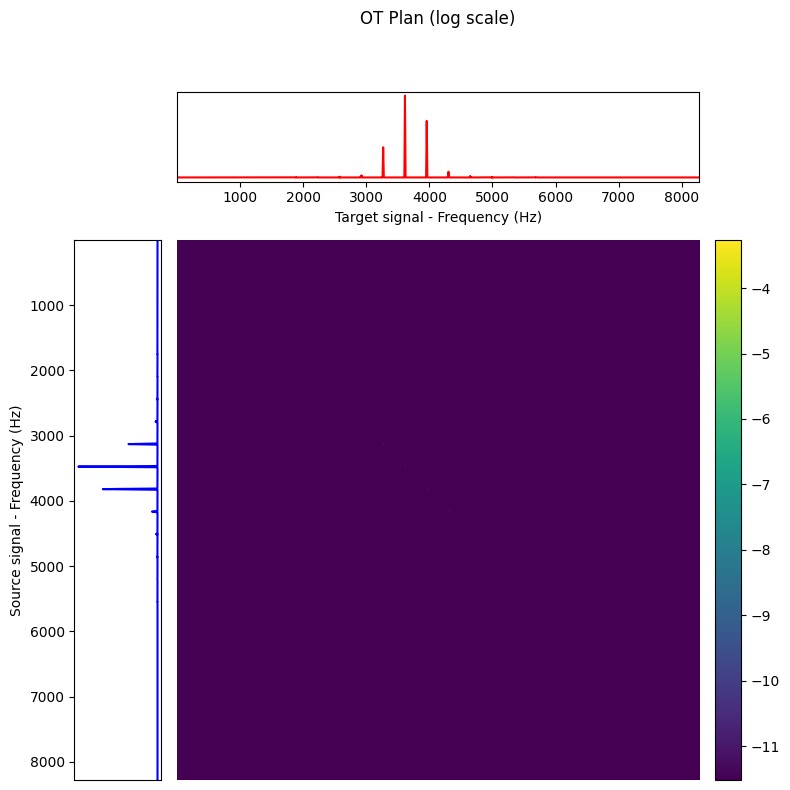

In [10]:
plot_plan_spectra(np.arange(len(support)), 
                  flat_source, 
                  flat_target, 
                  plan, 
                  source_freq_start=0, 
                  source_freq_end=-1, 
                  target_freq_start=0,
                  target_freq_end=-1)


In [11]:
def generate_interpolated_support(alpha, n_rows, support):
    n_cols = len(support) // n_rows
    interpolated_support = np.zeros((n_rows * n_cols, n_rows * n_cols, 2))

    for i in range(len(support)):
        for j in range(len(support)):
            interpolated_position = (1 - alpha) * support[i] + alpha * support[j]
            interpolated_support[i, j] = interpolated_position

    return interpolated_support

alpha = 0.5

interpolation_support = generate_interpolated_support(alpha, top, support)
interpolation = plan

In [12]:
def adapt_interpolant(plan, interpolation_support, source): 
    adapted_interpolation = np.zeros_like(source)

    for i in range(interpolation_support.shape[0]):
        for j in range(interpolation_support.shape[1]):
            new_point = np.round(interpolation_support[i, j]).astype(np.int64)
            adapted_interpolation[new_point[1], new_point[0]] += plan[i, j]

    return np.array(adapted_interpolation)

adapted_interpolation = adapt_interpolant(interpolation, interpolation_support, source)

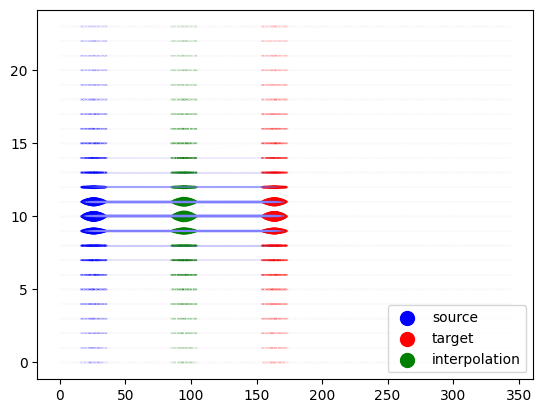

In [13]:
adapted_interpolation_clipped = np.clip(adapted_interpolation.flatten(), 1e-8, None)

plt.scatter(support[:,0], support[:,1], c="b", s=source_clipped*1000)
plt.scatter(support[:,0], support[:,1], c="r", s=target_clipped*1000)
plt.scatter(support[:,0], support[:,1], c="g", s=adapted_interpolation_clipped*1000)
ot.plot.plot2D_samples_mat(support, support, plan, c=[0.5, 0.5, 1])

plt.scatter([], [], c="b", label="source", s=100)
plt.scatter([], [], c="r", label="target", s=100)
plt.scatter([], [], c="green", label="interpolation", s=100)
plt.legend(loc="lower right")

In [14]:
interpolation_stft = np.zeros_like(source_stft)

interpolation_stft[:top, :]  = adapted_interpolation

interpolation_signal = librosa.griffinlim(interpolation_stft, n_iter=100)

fft_signals = [source_signal, target_signal, interpolation_signal]
fft_titles = ['source', 'target',  'interpolation']
audio_widgets = [audio_widget(signal, title) for signal, title in zip(fft_signals, fft_titles)]

grid = widgets.VBox(audio_widgets)
grid